# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from PIL import Image
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
base_loc = "/datasets/Project_data/"
#base_loc = "Project_data/"

In [4]:
train_doc = np.random.permutation(open(f'{base_loc}train.csv').readlines())
val_doc = np.random.permutation(open(f'{base_loc}val.csv').readlines())
num_class=5

#### Functions to crop, resize and normalize images

In [5]:
def crop_resize(img, wd, ht):
    width=img.size[0]
    height=img.size[1]
    aspect=width/height
    crop_aspect=1

    if aspect > crop_aspect:
        #Crop left and right edges
        new_width=int(crop_aspect*height)
        offset=(width - new_width)/2
        resize=(offset, 0, width-offset, height)
    else:
        #Crop the top and bottom
        new_height=int(width/crop_aspect)
        offset=(height - new_height)/2
        resize=(0, offset, width, height-offset)

    img_cropped=img.crop(resize).resize((wd, ht), Image.ANTIALIAS)
    return img_cropped


def normalize(img, mode=1, img_width=100, img_height=100): 
    ret_img=np.zeros((img_width, img_height))
    if mode==1:
        ret_img = (img - np.min(img))/(np.max(img)- np.min(img))
    if mode==2:
        ret_img = img/255
    return ret_img

#### Test cropping and resizing function

In [6]:
#Get 2 sample images to test cropping and resizing function
sample_file_360X360=f'{base_loc}train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00070.png'
sample_file_160X120=f'{base_loc}train/WIN_20180926_18_09_50_Pro_Right_Swipe_new/WIN_20180926_18_09_50_Pro_00071.png'

img_360 = Image.open(sample_file_360X360)
img_360_newsize = crop_resize(img_360, 100, 100)
img_160 = Image.open(sample_file_160X120)
img_160_newsize = crop_resize(img_160, 100, 100)

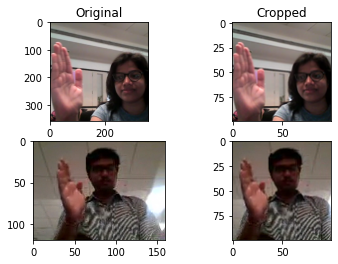

In [7]:
#Show sample cropped and resized images
import matplotlib.pyplot as plt
ax = plt.subplot(2, 2, 1)
plt.imshow(np.array(img_360))
plt.title('Original')
ax = plt.subplot(2, 2, 2)
plt.imshow(np.array(img_360_newsize))
plt.title('Cropped')
ax = plt.subplot(2, 2, 3)
plt.imshow(np.array(img_160))
ax = plt.subplot(2, 2, 4)
plt.imshow(np.array(img_160_newsize))
plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def generator(source_path, folder_list, batch_size, img_mode=1, normalize_mode=1, img_width=100, img_height=100):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = []
    if img_mode==1:
        img_idx=[2*i for i in range(15)]
    if img_mode==2:
        img_idx=[5*i for i in range(6)]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_width,img_height,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_newsize = crop_resize(image, img_width, img_height)
                    image_newsize = np.array(image_newsize)
                    
                    batch_data[folder,idx,:,:,0] = normalize(image_newsize[:,:,0], normalize_mode, img_width, img_height)
                    batch_data[folder,idx,:,:,1] = normalize(image_newsize[:,:,1], normalize_mode, img_width, img_height)
                    batch_data[folder,idx,:,:,2] = normalize(image_newsize[:,:,2], normalize_mode, img_width, img_height)
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #yield the batch_data and the batch_labels
            
        if int(len(t)%batch_size!=0):
            batch_size_rem = int(len(t)%batch_size)
            batch_labels = np.zeros((batch_size_rem,5))
            batch_data = np.zeros((batch_size_rem,len(img_idx),img_width,img_height,3))
            for folder in range(0, batch_size_rem): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + ((num_batches)*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):
                    image = Image.open(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image_newsize = crop_resize(image, img_width, img_height)
                    image_newsize = np.array(image_newsize)

                    batch_data[folder,idx,:,:,0] = normalize(image_newsize[:,:,0])
                    batch_data[folder,idx,:,:,1] = normalize(image_newsize[:,:,1])
                    batch_data[folder,idx,:,:,2] = normalize(image_newsize[:,:,2])

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #yield the batch_data and the batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = f'{base_loc}/train'
val_path = f'{base_loc}/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 #choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [10]:
#Uncomment next to Test generator.
#train_generator = generator(train_path, train_doc, 600)
#next(train_generator)

#### Function to plot train and validation accuracies

In [11]:
def plot_accuracy(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    print(f" \n {'*'*40}")
    print(f"\nLast Epoch Model performance:")
    print(f"Train Categorical Accuracy : {acc[-1]:.2f}, Validation Categorical Accuracy: {val_acc[-1]:.2f} ")
    print(f"Train Loss : {loss[-1]:.2f}, Validation Loss: {val_loss[-1]:.2f} ")
    print(f" \n {'*'*40}")
    
    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Categorical Accuracy')
    plt.plot(val_acc, label='Validation Categorical Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Categorical Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [12]:
def driver_function(model, batch_size, img_mode=1, normalize_mode=1, optimiser = 'adam', img_width=100, img_height=100):
    train_generator = generator(train_path, train_doc, batch_size, img_mode, normalize_mode, img_width, img_height)
    val_generator = generator(val_path, val_doc, batch_size, img_mode, normalize_mode, img_width, img_height)
    curr_dt_time = datetime.datetime.now()
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    print(f"Model Folder will be: {model_name}")
    if not os.path.exists(model_name):
        os.mkdir(model_name)
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    callbacks_list = [checkpoint, LR, early_stop]
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
    
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps,
                    class_weight=None, workers=1, initial_epoch=0)
    plot_accuracy(history)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, LSTM, \
                                    Conv3D, Conv2D, MaxPool3D, MaxPooling2D, MaxPool2D, ConvLSTM2D, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers, layers

In [14]:
#To handle bigger batch size
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

## 3D CNN Models

#### Experiment 1: Batch size 150. 15 images per video.

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 50, 50, 16)     0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 25, 25, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 25, 25, 32)     0         
______________________________________________________________

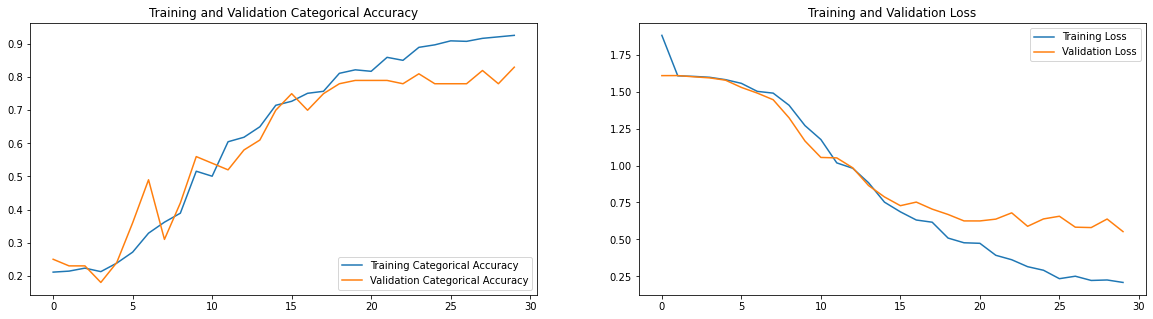

In [15]:
batch_size=150
#3D CNN
model = Sequential([
     Conv3D(16,3,padding='same',activation='relu',input_shape=(15,100, 100, 3)),
     MaxPool3D(),
     Dropout(.2),
     Conv3D(32,3,padding='same',activation='relu'),
     MaxPool3D(),
     Dropout(.2),
     Conv3D(64,3,padding='same',activation='relu'),
     MaxPool3D(),
     Dropout(.2),
     Flatten(),
     Dense(128,activation='relu'),
     Dropout(.2),
     Dense(5,activation='softmax')
   ])
# Drive the experiment
driver_function(model, batch_size)

#### Experiment 2: Above model is overfitting. Check Batch size 100.

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 3, 25, 25, 32)     0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 25, 25, 32)     0         
____________________________________________________________

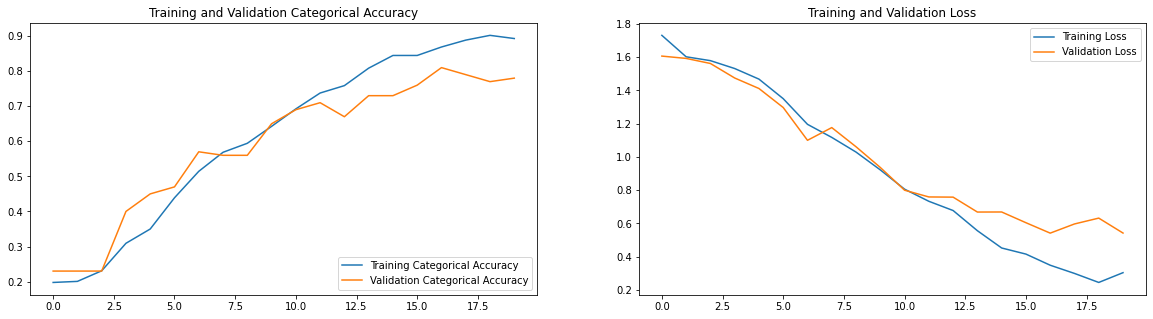

In [16]:
batch_size = 100
#3D CNN
model = Sequential([
     Conv3D(16,3,padding='same',activation='relu',input_shape=(15,100, 100, 3)),
     MaxPool3D(),
     Dropout(.2),
     Conv3D(32,3,padding='same',activation='relu'),
     MaxPool3D(),
     Dropout(.2),
     Conv3D(64,3,padding='same',activation='relu'),
     MaxPool3D(),
     Dropout(.2),
     Flatten(),
     Dense(128,activation='relu'),
     Dropout(.2),
     Dense(5,activation='softmax')
   ])
# Drive the experiment
driver_function(model, batch_size)

#### Experiment 3: 100 batch size model is better. But let's check Batch size 50

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 50, 50, 32)     13856     
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 3, 25, 25, 32)     0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 25, 25, 32)     0         
____________________________________________________________

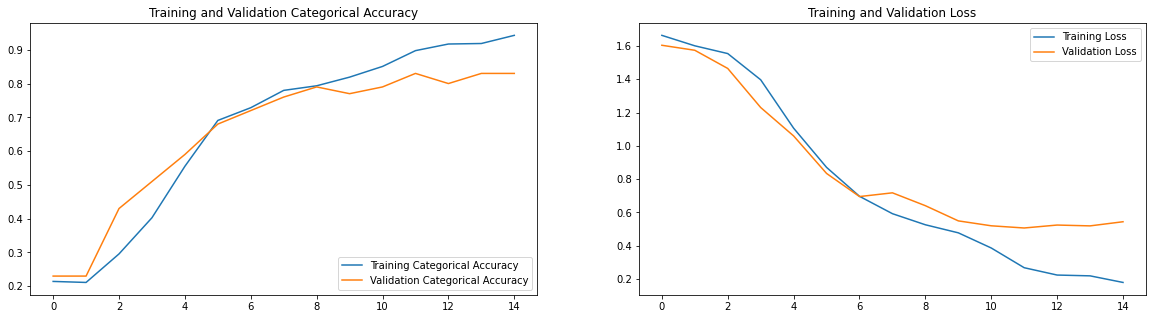

In [17]:
batch_size=50
#3D CNN
model = Sequential([
     Conv3D(16,3,padding='same',activation='relu',input_shape=(15,100, 100, 3)),
     MaxPool3D(),
     Dropout(.2),
     Conv3D(32,3,padding='same',activation='relu'),
     MaxPool3D(),
     Dropout(.2),
     Conv3D(64,3,padding='same',activation='relu'),
     MaxPool3D(),
     Dropout(.2),
     Flatten(),
     Dense(128,activation='relu'),
     Dropout(.2),
     Dense(5,activation='softmax')
   ])
# Drive the experiment
driver_function(model, batch_size)

#### Choosing Batch Size 100 for further experiments as model with this size is performing best

#### Experiment 4: Batch size 100. 6 images per video.

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 6, 100, 100, 16)   1312      
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 3, 50, 50, 16)     0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 50, 50, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 3, 50, 50, 32)     13856     
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 2, 25, 25, 32)     0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2, 25, 25, 32)     0         
____________________________________________________________

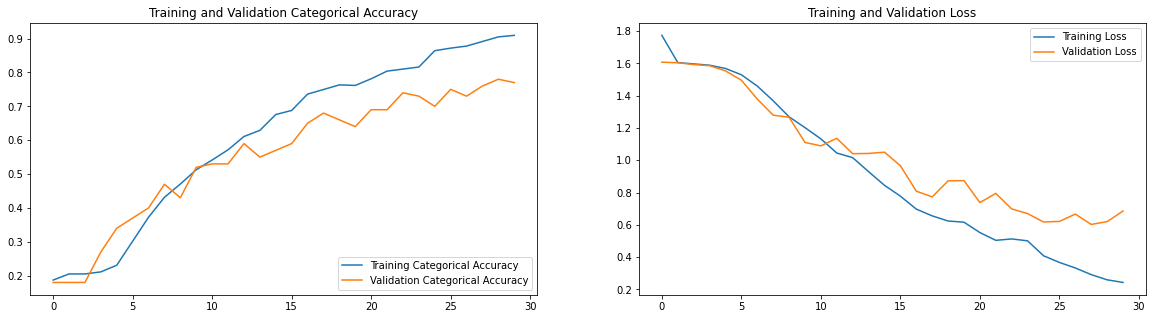

In [18]:
batch_size=100
#3D CNN
model = Sequential([
     Conv3D(16,3,padding='same',activation='relu',input_shape=(6,100, 100, 3)),
     MaxPool3D(padding='same'),
     Dropout(.2),
     Conv3D(32,3,padding='same',activation='relu'),
     MaxPool3D(padding='same'),
     Dropout(.2),
     Conv3D(64,3,padding='same',activation='relu'),
     MaxPool3D(padding='same'),
     Dropout(.2),
     Flatten(),
     Dense(128,activation='relu'),
     Dropout(.2),
     Dense(5,activation='softmax')
   ])
# Drive the experiment
driver_function(model, batch_size, img_mode=2)

#### Experiment 5: Batch size 100. 6 images per video. Img size 64X64.

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 6, 64, 64, 16)     1312      
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 3, 32, 32, 16)     0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 3, 32, 32, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 3, 32, 32, 32)     13856     
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 2, 16, 16, 32)     0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 2, 16, 16, 32)     0         
____________________________________________________________

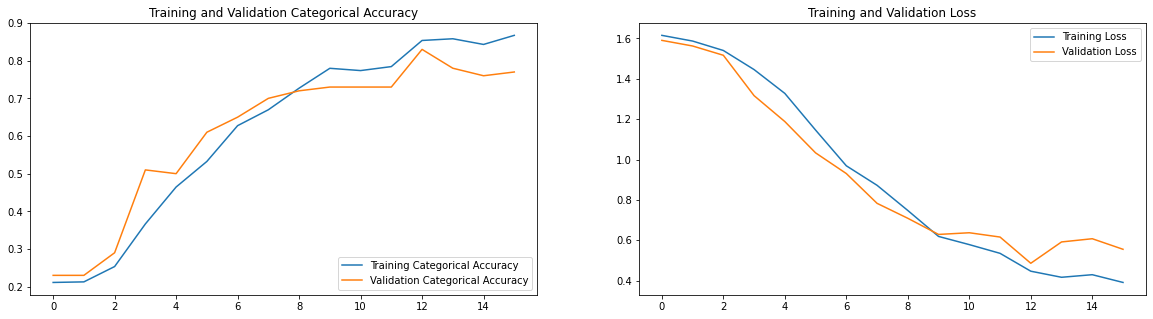

In [19]:
batch_size=100
#3D CNN
model = Sequential([
     Conv3D(16,3,padding='same',activation='relu',input_shape=(6,64,64,3)),
     MaxPool3D(padding='same'),
     Dropout(.2),
     Conv3D(32,3,padding='same',activation='relu'),
     MaxPool3D(padding='same'),
     Dropout(.2),
     Conv3D(64,3,padding='same',activation='relu'),
     MaxPool3D(padding='same'),
     Dropout(.2),
     Flatten(),
     Dense(128,activation='relu'),
     Dropout(.2),
     Dense(5,activation='softmax')
   ])
# Drive the experiment
driver_function(model, batch_size, img_mode=2, img_width=64, img_height=64)

#### 100 batch size, 6 images per video, and 64X64 image size is giving better accuracy and is training a lot faster too.

#### Experiment 6: Batch size 100. 6 images per video. Img size 64X64. /255 Normalization.

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 6, 64, 64, 16)     1312      
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 3, 32, 32, 16)     0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 3, 32, 32, 16)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 3, 32, 32, 32)     13856     
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 2, 16, 16, 32)     0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 2, 16, 16, 32)     0         
___________________________________________________________

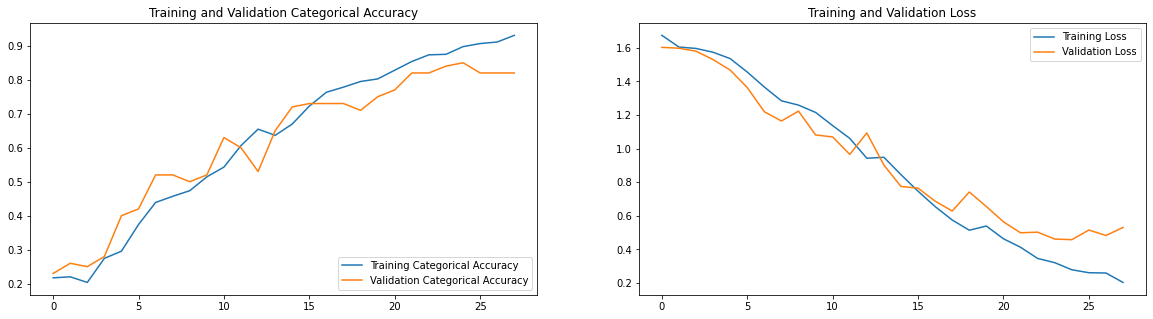

In [30]:
batch_size=100
#3D CNN
model = Sequential([
     Conv3D(16,3,padding='same',activation='relu',input_shape=(6,64,64,3)),
     MaxPool3D(padding='same'),
     Dropout(.2),
     Conv3D(32,3,padding='same',activation='relu'),
     MaxPool3D(padding='same'),
     Dropout(.2),
     Conv3D(64,3,padding='same',activation='relu'),
     MaxPool3D(padding='same'),
     Dropout(.2),
     Flatten(),
     Dense(128,activation='relu'),
     Dropout(.2),
     Dense(5,activation='softmax')
   ])
# Drive the experiment
driver_function(model, batch_size, img_mode=2, normalize_mode=2, img_width=64, img_height=64)

## 2D CNN with LSTM Models

#### Experiment 7: Batch size 100. 30 filters. 6 images per video. Img size 64X64.

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 62, 62, 30)        35760     
_________________________________________________________________
dropout_24 (Dropout)         (None, 62, 62, 30)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 115320)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               14761088  
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 645       
Total params: 14,797,493
Trainable params: 14,797,493
Non-tr

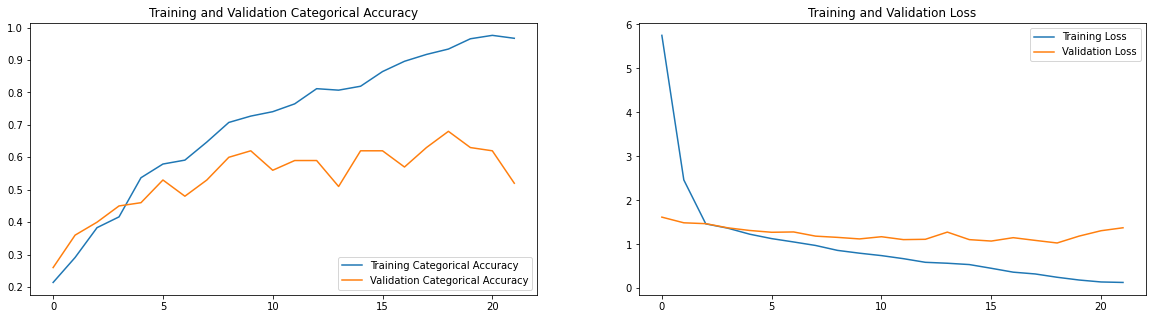

In [21]:
batch_size=100
#2D CNN with LSTM Model with 30 filters
model = Sequential([
     ConvLSTM2D(filters=30, kernel_size=3, input_shape=(6,64,64,3)),
     Dropout(.2),
     Flatten(),
     Dense(128,activation='relu'),
     Dropout(.2),
     Dense(5,activation='softmax')
   ])
# Drive the experiment
driver_function(model, batch_size, img_mode=2, img_width=64, img_height=64)

#### Experiment 8: Batch size 100. 50 filters. 6 images per video. Img size 64X64.

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 62, 62, 50)        95600     
_________________________________________________________________
dropout_26 (Dropout)         (None, 62, 62, 50)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 192200)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               24601728  
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 645       
Total params: 24,697,973
Trainable params: 24,697,973
Non-tr

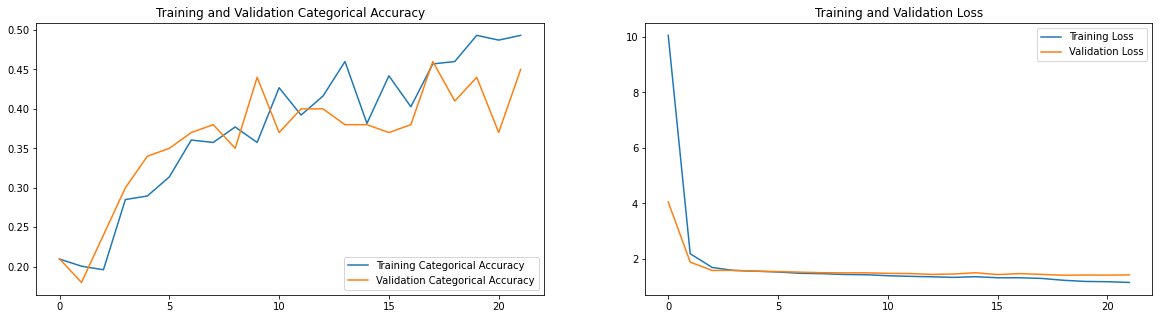

In [22]:
batch_size=100
#2D CNN with LSTM Model with 30 filters
model = Sequential([
     ConvLSTM2D(filters=50, kernel_size=3, input_shape=(6,64,64,3)),
     Dropout(.2),
     Flatten(),
     Dense(128,activation='relu'),
     Dropout(.2),
     Dense(5,activation='softmax')
   ])
# Drive the experiment
driver_function(model, batch_size, img_mode=2, img_width=64, img_height=64)

## Time Distributed 2D CNN with GRU Model

#### Experiment 9: Batch size 100. 15 images per video. Img size 100*100

In [23]:
#driver_function(model, batch_size, img_mode=1, normalize_mode=1, optimiser = 'adam', img_width=100, img_height=100)

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100, 100, 32)  4640      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 50, 50, 64)    18496     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 50, 50, 64)    256       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 25, 25, 64)    0         
____________________________________________________________

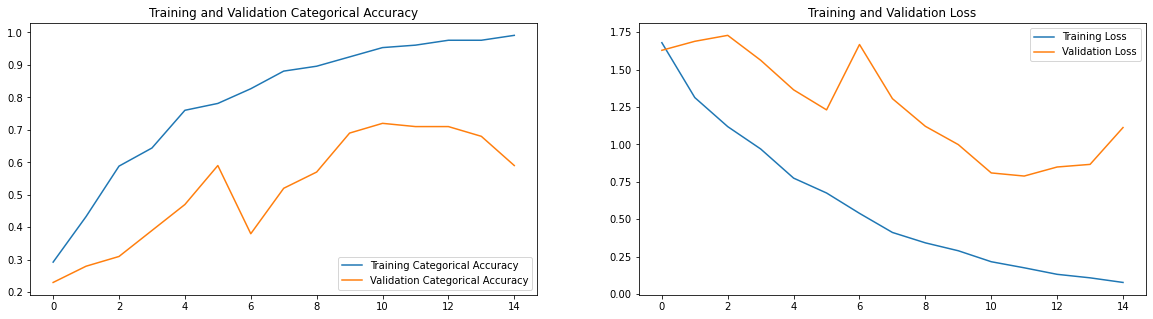

In [24]:
batch_size = 100
model = Sequential([
    TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=(15,100, 100, 3)),
    TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    GRU(128),
    Dense(128,activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])
driver_function(model, batch_size, img_mode=1, img_width=100, img_height=100)

#### Experiment 10: Batch size 50. 6 images per video. Img size 100*100

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 6, 100, 100, 16)   448       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 6, 100, 100, 32)   4640      
_________________________________________________________________
time_distributed_9 (TimeDist (None, 6, 50, 50, 32)     0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 6, 50, 50, 64)     18496     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 6, 50, 50, 64)     256       
_________________________________________________________________
time_distributed_12 (TimeDis (None, 6, 25, 25, 64)     0         
____________________________________________________________

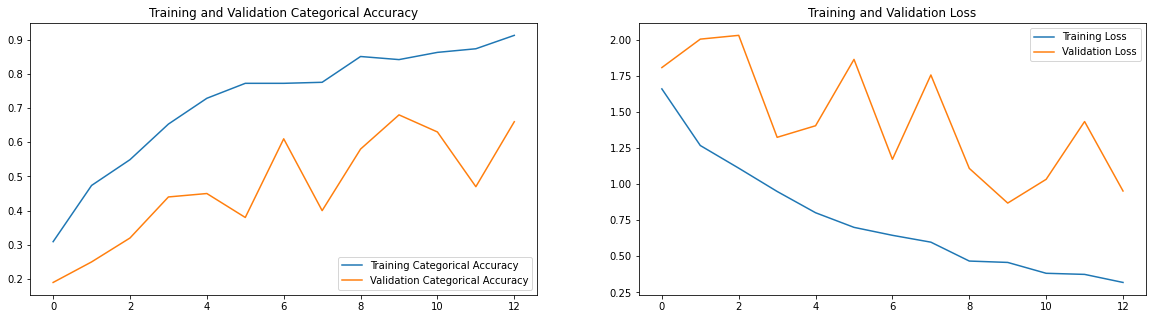

In [25]:
batch_size = 50
model = Sequential([
    TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=(6,100, 100, 3)),
    TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    GRU(128),
    Dense(128,activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])
driver_function(model, batch_size, img_mode=2, img_width=100, img_height=100)

#### Experiment 11: Batch size 100. 15 images per video. Img size 64*64

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 15, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 64, 64, 32)    4640      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 32, 32, 32)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 32, 32, 64)    18496     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 32, 32, 64)    256       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 16, 16, 64)    0         
___________________________________________________________

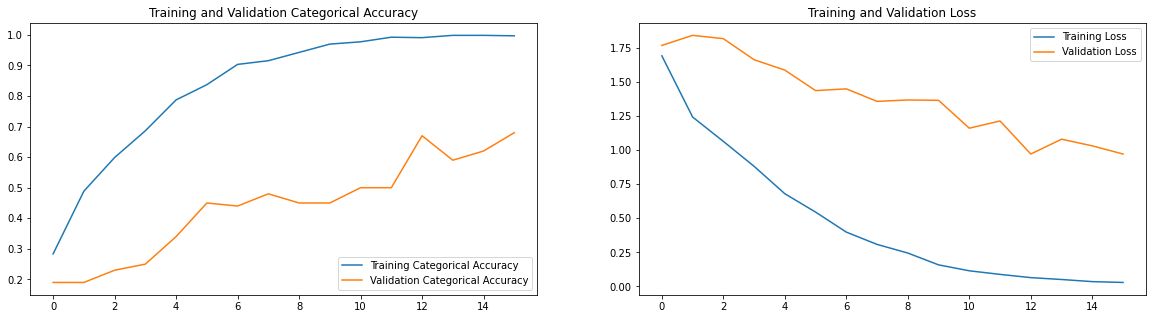

In [26]:
batch_size = 100
model = Sequential([
    TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=(15,64, 64, 3)),
    TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    GRU(128),
    Dense(128,activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])
driver_function(model, batch_size, img_mode=1, img_width=64, img_height=64)

#### Experiment 12: Batch size 50. 15 images per video. Img size 64*64

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 15, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 15, 64, 64, 32)    4640      
_________________________________________________________________
time_distributed_23 (TimeDis (None, 15, 32, 32, 32)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 15, 32, 32, 64)    18496     
_________________________________________________________________
time_distributed_25 (TimeDis (None, 15, 32, 32, 64)    256       
_________________________________________________________________
time_distributed_26 (TimeDis (None, 15, 16, 16, 64)    0         
___________________________________________________________

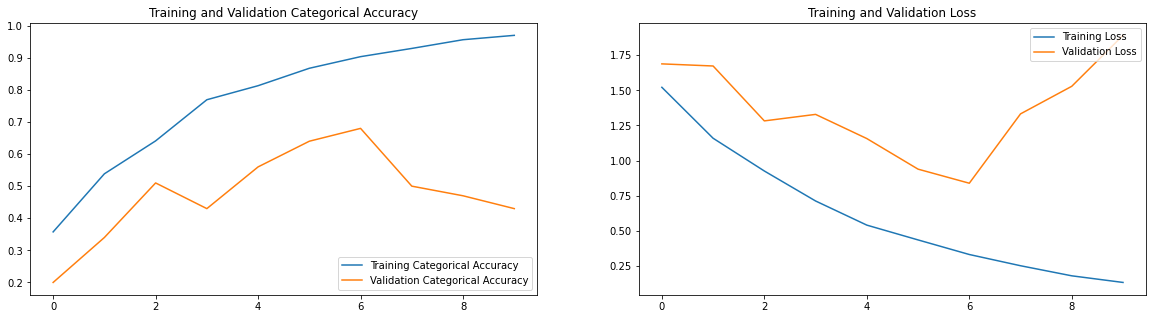

In [27]:
batch_size = 50
model = Sequential([
    TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=(15,64, 64, 3)),
    TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    GRU(128),
    Dense(128,activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])
driver_function(model, batch_size, img_mode=1, img_width=64, img_height=64)

#### Experiment 13: Batch size 50. 6 images per video. Img size 64*64

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, 6, 64, 64, 16)     448       
_________________________________________________________________
time_distributed_29 (TimeDis (None, 6, 64, 64, 32)     4640      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 6, 32, 32, 32)     0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 6, 32, 32, 64)     18496     
_________________________________________________________________
time_distributed_32 (TimeDis (None, 6, 32, 32, 64)     256       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 6, 16, 16, 64)     0         
___________________________________________________________

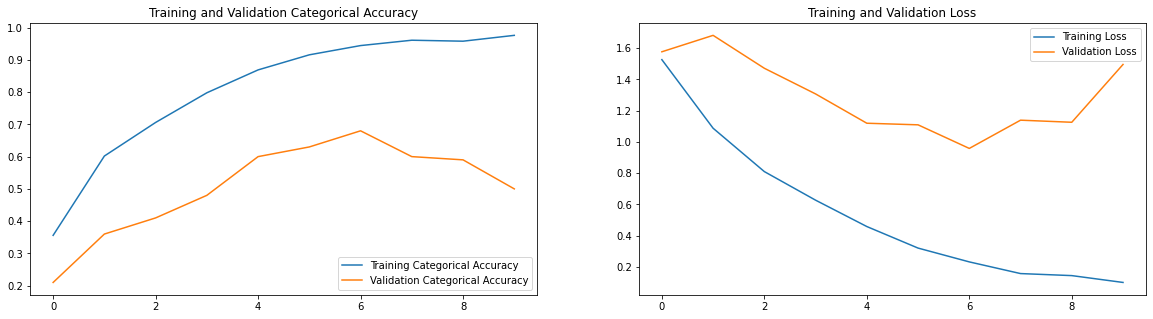

In [28]:
batch_size = 50
model = Sequential([
    TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=(6,64, 64, 3)),
    TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    GRU(128),
    Dense(128,activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])
driver_function(model, batch_size, img_mode=2, img_width=64, img_height=64)

#### Experiment 14: Batch size 50. 6 images per video. Img size 64*64, Min max scaler

Model Folder will be: model_init_2021-06-2812_15_21.390685/
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_35 (TimeDis (None, 6, 64, 64, 16)     448       
_________________________________________________________________
time_distributed_36 (TimeDis (None, 6, 64, 64, 32)     4640      
_________________________________________________________________
time_distributed_37 (TimeDis (None, 6, 32, 32, 32)     0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 6, 32, 32, 64)     18496     
_________________________________________________________________
time_distributed_39 (TimeDis (None, 6, 32, 32, 64)     256       
_________________________________________________________________
time_distributed_40 (TimeDis (None, 6, 16, 16, 64)     0         
___________________________________________________________

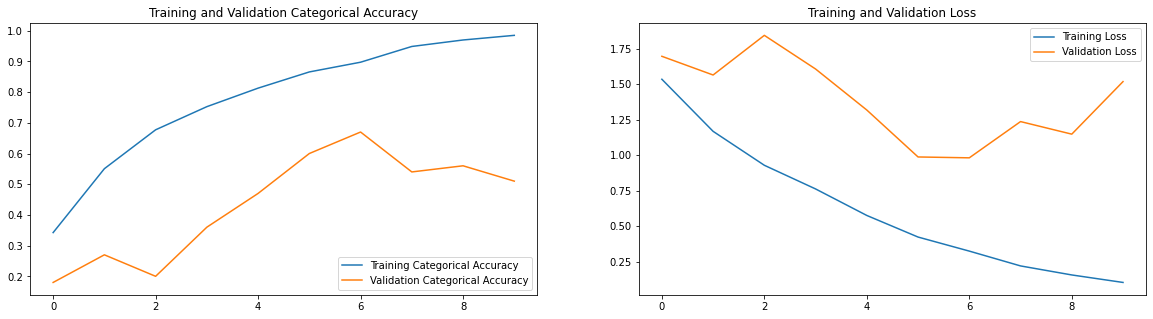

In [29]:
batch_size = 50
model = Sequential([
    TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=(6,64, 64, 3)),
    TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),
    GRU(128),
    Dense(128,activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])
driver_function(model, batch_size, img_mode=2, normalize_mode=1, img_width=64, img_height=64)